In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('/Users/haixiangliu/Documents/水质数据及代码模型/water_clean_data.csv')

In [3]:
data.columns=['datetime','water_level','do','miss','input_wind_throughput','input_wind_openness','ts','input_water_cod','output_water_cod','input_water_ammonia','output_water_ammonia','input_water_ph','output_water_phosphorus','input_water_ss','output_water_ss']

In [4]:
index_array=[]
for d in data['output_water_cod']:
    if d>=50:
        index_array.append(1)  
    else:
        index_array.append(0)
data['label']=pd.DataFrame(index_array)

In [5]:
datetime_array=[]
for value in data['datetime']:
    datetime_array.append(value)
data[data<0]=np.nan
data['datetime']=pd.DataFrame(datetime_array)
data = data.fillna(0.0)

In [6]:
data.head()

,datetime,water_level,do,miss,input_wind_throughput,input_wind_openness,ts,input_water_cod,output_water_cod,input_water_ammonia,output_water_ammonia,input_water_ph,output_water_phosphorus,input_water_ss,output_water_ss,label
0,2010-07-10 16:00:00,5.52,2.3,137.0,0.0,0.0,1.278745e+09,214,24,5.0,7.0,6.0,0.0,1192.0,8.0,0
1,2010-07-10 18:00:00,4.45,1.9,142.0,0.0,0.0,1.278752e+09,292,22,4.0,6.0,6.0,0.0,419.0,6.0,0
2,2010-07-10 20:00:00,4.46,1.4,117.0,0.0,0.0,1.278760e+09,269,22,4.0,6.0,6.0,0.0,437.0,6.0,0
3,2010-07-10 22:00:00,5.23,3.8,1463.0,5786.0,100.0,1.278767e+09,242,24,6.0,7.0,6.0,0.0,254.0,8.0,0
4,2010-07-11 04:00:00,5.00,3.3,1490.0,5881.0,100.0,1.278788e+09,324,24,20.0,7.0,6.0,0.0,176.0,9.0,0


In [78]:
Y_data=data['label']
X_data = data.drop(['label','datetime','output_water_cod'],axis=1)

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=0)

### Pearsonr相关分析 

In [10]:
from scipy.stats import pearsonr
columns = X_train.columns
feature_importance = [(column,pearsonr(X_train[column],y_train)[0]) for column in columns]
feature_importance.sort(key=lambda x:x[1])

In [11]:
feature_importance

[('ts', -0.041199339476320644),
 ('input_water_ammonia', -0.022279401895139012),
 ('input_water_ss', -0.01738716429699198),
 ('miss', -0.01652140599810774),
 ('input_wind_openness', -0.007414371537875724),
 ('input_wind_throughput', -0.006731947285925133),
 ('input_water_cod', -0.0060706085767087475),
 ('water_level', -0.0007800246532163351),
 ('output_water_ss', 0.0014334236138385205),
 ('do', 0.010255560684937354),
 ('input_water_ph', 0.026279267183042437),
 ('output_water_ammonia', 0.06726247963068453),
 ('output_water_phosphorus', 0.0870890064520124)]

通过Pearson分析每个特征值与label的线性关系，得：每个特征值与label之间的线性关系并不明显,在这里，Pearson相关没有很明显的作用

### MIC

In [12]:
from minepy import MINE

In [16]:
m = MINE()
x = data['input_water_cod']
y = data['label']
m.compute_score(x,y)
print(m.mic())

0.00793071729634442


In [17]:
m = MINE()
y = data['label']
for column in data.columns:
    if column!='datetime':
        x= data[column]
        m.compute_score(x,y)
        print(column +' : ' +str(m.mic()))

water_level : 0.002395532052798779
do : 0.0017971393226505008
miss : 0.014773796892369106
input_wind_throughput : 0.006235024414187478
input_wind_openness : 9.90066956105291e-05
ts : 0.0236569895924308
input_water_cod : 0.00793071729634442
output_water_cod : 0.0236569895924308
input_water_ammonia : 0.009695577082845535
output_water_ammonia : 0.002891742609696642
input_water_ph : 0.004277296060862747
output_water_phosphorus : 0.004122247649518881
input_water_ss : 0.006299044508360956
output_water_ss : 0.0005898417083315099
label : 0.0236569895924308


结果中ts、output_water_cod、label的值是相同的。从结果可得，并没有很突出的特征变量

### 稳定性选择-RandomizedLasso

In [70]:
#抽样进行训练，预测
data_0=data[data['label']==0]
data_1=data[data['label']==1]
#抽取label=0的数据的20%
sample_data_0 = data_0.sample(frac=0.02)
#数据中label=1的所有数据
sampled_data1=data_1.append(sample_data_0)

In [71]:
from sklearn.linear_model import RandomizedLasso
Y= sampled_data1['label']
X= sampled_data1.drop(['datetime','label'],axis=1)
names = data.columns
rlasso = RandomizedLasso()
rlasso.fit(X,Y)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


RandomizedLasso(alpha='aic', eps=2.220446049250313e-16, fit_intercept=True,
        max_iter=500, memory=None, n_jobs=1, n_resampling=200,
        normalize=True, pre_dispatch='3*n_jobs', precompute='auto',
        random_state=None, sample_fraction=0.75, scaling=0.5,
        selection_threshold=0.25, verbose=False)

In [72]:
feature_importance =sorted(zip(map(lambda x:round(x,4),rlasso.scores_),names))

In [73]:
feature_importance

[(0.0, 'datetime'),
 (0.0, 'do'),
 (0.0, 'input_water_ss'),
 (0.0, 'input_wind_throughput'),
 (0.0, 'miss'),
 (0.0, 'output_water_cod'),
 (0.0, 'ts'),
 (0.01, 'water_level'),
 (0.05, 'input_water_ammonia'),
 (0.115, 'input_wind_openness'),
 (0.15, 'output_water_ammonia'),
 (0.31, 'output_water_phosphorus'),
 (0.455, 'input_water_ph'),
 (1.0, 'input_water_cod')]

通过稳定性选择所得到的结果，特征input_water_cod的重要性最高，这里包含多个结果为0的特征，说明他们的可用性很小，对预测结果的影响也很小

In [74]:
data_0=data[data['label']==0]
data_1=data[data['label']==1]
sample_data_0 = data_0.sample(frac=0.02)
sampled_data=data_1.append(sample_data_0)

In [75]:
X=sampled_data[['input_wind_openness', 'output_water_ammonia','input_water_ammonia', 'input_water_ph','input_water_cod']]
Y = sampled_data['label']

model = XGBClassifier(n_estimators=100,max_depth=3,objective='multi:softmax',num_class=2,subsample=0.8,colasmple_btree=0.8)
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.4)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [76]:
print("Accuracy : %.2f%%"%(accuracy_score(y_test,y_pred)*100.0))

Accuracy : 92.11%


Text(91.68,0.5,'predicted lable')

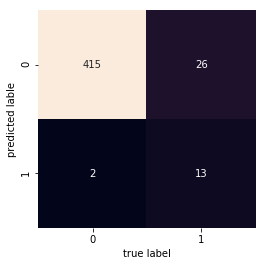

In [77]:
mat = confusion_matrix(y_test,y_pred)
sns.heatmap(mat.T,square = True,annot=True,fmt='o',cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted lable')

如果按照稳定性来选择特征向量，在模型预测试前去掉结果为0的特征再进行预测，模型评估得分为92.11%

### RFE

In [23]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [79]:
#递归特征消除 Recursive feature elimination (RFE)
from sklearn.feature_selection import RFE
names = data.columns
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.5, random_state=0)
# use linear regression as the model
rf = RandomForestClassifier()
# rank all features, i.e continue the elimination until the last one
rfe = RFE(rf, n_features_to_select=1,verbose=1)
rfe.fit(X_train, y_train)

print("Features sorted by their rank:")
feature_importance=(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names),reverse=True))
feature_importance

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Features sorted by their rank:


[(13, 'input_wind_throughput'),
 (12, 'miss'),
 (11, 'output_water_cod'),
 (10, 'output_water_phosphorus'),
 (9, 'water_level'),
 (8, 'input_water_ammonia'),
 (7, 'input_water_ph'),
 (6, 'datetime'),
 (5, 'output_water_ammonia'),
 (4, 'ts'),
 (3, 'input_water_cod'),
 (2, 'do'),
 (1, 'input_wind_openness')]

### 使用线性模型L1做特征选择 

In [81]:
Y_data=sampled_data['label']
X_data = sampled_data.drop(['label','datetime','output_water_cod'],axis=1)

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.1, random_state=0)
lr=LogisticRegression(penalty='l1',random_state=0).fit(X_train,y_train)
pred=lr.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test,pred))
columns = sampled_data1.columns
feature_importance=[(i[0],i[1]) for i in zip(columns,lr.coef_[0])]
feature_importance.sort(key=lambda x:np.abs(x[1]))
#特征系数
feature_importance

0.8033088235294118


[('input_wind_openness', 9.953855407627596e-10),
 ('do', -3.6910556632770215e-05),
 ('miss', 3.757283687018759e-05),
 ('ts', -0.0015522173478056626),
 ('input_water_ph', -0.0018818637285813273),
 ('input_wind_throughput', 0.002369396835911019),
 ('water_level', 0.009138906698680524),
 ('input_water_cod', -0.041456228107871),
 ('input_water_ammonia', 0.05460413057214736),
 ('output_water_phosphorus', -0.10004193691786362),
 ('output_water_cod', 0.10791309079893624),
 ('datetime', -0.3194875149025937),
 ('output_water_ammonia', 1.0695216643088197)]

### 使用线性模型L2做特征选择 

In [83]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_data,Y_data,test_size=0.1, random_state=0)
lr=LogisticRegression(penalty='l2',random_state=0).fit(X_train2,y_train2)
pred=lr.predict_proba(X_test2)[:,1]
print(roc_auc_score(y_test2,pred))
 
feature_importance=[(i[0],i[1]) for i in zip(columns,lr.coef_[0])]
feature_importance.sort(key=lambda x:np.abs(x[1]))
feature_importance


0.7886029411764706


[('water_level', -4.690830289281672e-19),
 ('output_water_ammonia', 4.759519749157767e-19),
 ('output_water_phosphorus', -5.3359520363545896e-18),
 ('datetime', -5.664942360652367e-18),
 ('input_water_ammonia', -6.6745428513588046e-18),
 ('output_water_cod', 9.141824579710758e-18),
 ('input_water_cod', -4.353053902199364e-17),
 ('input_wind_throughput', -5.229128261990831e-17),
 ('ts', -3.0901270243821086e-16),
 ('input_water_ph', -7.872180048774718e-16),
 ('miss', -1.821098413699369e-15),
 ('do', -5.11883135908297e-15),
 ('input_wind_openness', -1.5715552704557107e-09)]

### 使用平均精确率减少做特征选择

In [28]:
from sklearn.metrics import r2_score
from collections import defaultdict

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
rf=RandomForestClassifier(n_estimators=300,max_depth=7,min_samples_split=10,min_samples_leaf=10,n_jobs=7,random_state=0)
scores = defaultdict(list)

In [29]:
from sklearn.cross_validation import ShuffleSplit
for train_idx, test_idx in ShuffleSplit(len(X_train), 3, 0.3):
    x_train, X_test = X_train.values[train_idx], X_train.values[test_idx]
    Y_train, Y_test = y_train.values[train_idx], y_train.values[test_idx]
    r = rf.fit(x_train, Y_train)
    acc = r2_score(Y_test, rf.predict_proba(X_test)[:,1])
    for i in range(x_train.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(Y_test, rf.predict_proba(X_t)[:,1])
        scores[columns[i]].append((acc - shuff_acc) / acc)
feature_impotance=sorted([(round(np.mean(score), 4), feat) for feat, score in scores.items()])
feature_impotance

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[(-0.0012, 'water_level'),
 (-0.0009, 'datetime'),
 (-0.0009, 'input_water_ss'),
 (-0.0004, 'miss'),
 (-0.0001, 'input_wind_throughput'),
 (0.0007, 'output_water_ammonia'),
 (0.0021, 'input_water_ammonia'),
 (0.0032, 'do'),
 (0.0065, 'ts'),
 (0.0069, 'output_water_phosphorus'),
 (0.0072, 'input_water_ph'),
 (0.0084, 'output_water_cod'),
 (0.0184, 'input_wind_openness'),
 (1.2426, 'input_water_cod')]